In [1]:
# %matplotlib inline
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle
from joblib import load

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier # used with Linear SVC

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from multilabel import *

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Feng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
import string

del_punct = string.punctuation
del_punct = del_punct.replace("-", "")  # don't remove hyphens
rm_pattern = r"[{}]".format(del_punct)

def clean_text(text):
    text = text.lower()  # convert to all lower case
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(rm_pattern, "", text)  # remove punctuations
    text = re.sub(r'[0-9]', ' ', text)  # remove digits 0-9
    text = re.sub('\W', ' ', text)   # removes non-word character
    text = re.sub('\s+', ' ', text)  # removes extra spaces
    text = text.strip(' ')
    return text

In [13]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string

# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com"))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

# df_processed_text = pd.read_csv('processed_text.csv', usecols = ['cleaned_text'])

wordnet_lemmatizer = WordNetLemmatizer()

def text_lemmatizer(text):     
    tokens = word_tokenize(text)
    lemmatized_text = []
    
    for token in tokens:
        # lemmatized = wordnet_lemmatizer.lemmatize(token, pos='v')
        lemmatized_text.append(wordnet_lemmatizer.lemmatize(token, pos='v'))
        lemmatized_text.append(' ')
        
    return ''.join(lemmatized_text)

def text_cleaner(text, stop):
    text = clean_text(text)
    stop_free = " ".join([i for i in text.lower().split() if((i not in stop) and (not i.isdigit()))])
    punc_free = ''.join(i for i in stop_free if i not in exclude)
    normalized = " ".join(wordnet_lemmatizer.lemmatize(i) for i in punc_free.split())  
    
    return normalized



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Feng\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# len(train_text) == len(train_labels)
dataset_directory = "C:/Users/Feng/Coding projects/toxic-comments-datasets/"
train_df = pd.read_csv(dataset_directory + "train.csv.zip", usecols = ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
train_df = train_df.astype({'toxic':'int16',
                            'severe_toxic':'int16',
                            'obscene':'int16',
                            'threat':'int16',
                            'insult':'int16',
                            'identity_hate':'int16'})

train_df = train_df.dropna()  # I found 5 nan rows in cleaned_text, so I just drop those rows altogether
# print(train_df.info())


In [15]:
%%time
train_df['cleaner_text'] = train_df['comment_text'].map(lambda comments : text_cleaner(comments, stop))

CPU times: total: 28.4 s
Wall time: 28.5 s


In [22]:
# print(train_df.info())
display(train_df[train_df.severe_toxic==1]['cleaner_text'].tail())
# print(train_df.isna().sum())

159096    filthy stinking crow back dirty crow better de...
159099          fucking pathetic moron jimbo wale rootmyass
159281           lol gay never know good feel fuck woman as
159312    walter mercado antonio quite frankly fucker co...
159400    shalom semite get fuck kill son bitch leave wi...
Name: cleaner_text, dtype: object

In [7]:
print(train_df['cleaned_text'].head())

0    explanation why the edits made under my userna...
1    daww he matches this background colour i am se...
2    hey man i am really not trying to edit war it ...
3    more i can not make any real suggestions on im...
4    you sir are my hero any chance you remember wh...
Name: cleaned_text, dtype: object


In [8]:
LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train_text = train_df['cleaned_text']
train_labels = train_df[LABELS]

X_train_m, X_test_m, y_train_m, y_test_M = multilabel_train_test_split(train_text, train_labels, size=0.25)

X_train, X_test, y_train, y_test = train_test_split(train_text, train_labels, test_size=0.25)


In [5]:
# Define a pipeline combining a text feature extractor with multi lable classifier
countvec_NB_pipeline = Pipeline([
                ('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', MultinomialNB()) ])

tfidf_NB_pipeline = Pipeline([
                ('vectorizer', TfidfVectorizer(stop_words='english')),
                ('clf', MultinomialNB()) ])



## Precision vs Recall

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

FP = good comments wrongfully labeled toxic

FN = undetected toxic comments

Having high accuracy is misleading, since positive toxic labels are sparse. The question is, do I want high precision or high recall. Precision is a measure of true positives (correctly labeled toxic comments) relative to false positives (clean comments wrongfully labeled toxic). Recall measures true positives relative to false negatives (toxic comments that were not detected). In other words, do I want to minimize wrongfully labeled clean comments or undetected toxic comments. In my opinion, the former is preferred, since randomly deleting clean comments will upset users. Therefore, high precision is more preferred than high recall.

## CountVec + NB

In [7]:
scores_dict = {}
print(['accuracy', 'precision', 'recall', 'f1'])
for label in LABELS:
    print('... Processing {}'.format(label))
    # train the model using X_dtm & y
    # countvec_NB_pipeline.fit(X_train.iloc[0:10000], y_train[label].iloc[0:10000]) # train with a slice 
    countvec_NB_pipeline.fit(X_train, y_train[label])  # train with whole dataset

    # compute the testing accuracy
    pred = countvec_NB_pipeline.predict(X_test)
    test = y_test[label]
    
    scores = [accuracy_score(test, pred), precision_score(test, pred), recall_score(test, pred), f1_score(test, pred) ] 
    scores_dict[label] = scores
    # scores = np.round(scores, decimals = 2)
    
    print(np.round(scores, decimals = 2))

pred_scores = pd.DataFrame(scores_dict, index=['accuracy', 'precision', 'recall', 'f1'])
print(np.round(pred_scores.T, decimals=2))

['accuracy', 'precision', 'recall', 'f1']
... Processing toxic
[0.95 0.82 0.6  0.69]
... Processing severe_toxic
[0.99 0.46 0.42 0.44]
... Processing obscene
[0.97 0.79 0.58 0.67]
... Processing threat
[1.   0.25 0.06 0.09]
... Processing insult
[0.97 0.72 0.51 0.6 ]
... Processing identity_hate
[0.99 0.28 0.11 0.16]
               accuracy  precision  recall    f1
toxic              0.95       0.82    0.60  0.69
severe_toxic       0.99       0.46    0.42  0.44
obscene            0.97       0.79    0.58  0.67
threat             1.00       0.25    0.06  0.09
insult             0.97       0.72    0.51  0.60
identity_hate      0.99       0.28    0.11  0.16


## TFIDF + NB
TFIDF completely failed on precision and recall for the very sparse labels e.g. severe_toxic, threat, identity_hate. These 3 labels have < 1% of occurence.

In [122]:

scores_dict = {}
print(['accuracy', 'precision', 'recall', 'f1'])
for label in LABELS:
    print('... Processing {}'.format(label))
    # train the model using X_dtm & y
    # countvec_NB_pipeline.fit(X_train.iloc[0:10000], y_train[label].iloc[0:10000]) # train with a slice 
    tfidf_NB_pipeline.fit(X_train, y_train[label])  # train with whole dataset

    # compute the testing accuracy
    pred = tfidf_NB_pipeline.predict(X_test)
    test = y_test[label]
    
    scores = [accuracy_score(test, pred), precision_score(test, pred), recall_score(test, pred), f1_score(test, pred) ] 
    scores_dict[label] = scores
    
    print(np.round(scores, decimals = 2))

scores_tfidf_NB = pd.DataFrame(scores_dict, index=['accuracy', 'precision', 'recall', 'f1']).T
print(np.round(scores_tfidf_NB, decimals=2))

['accuracy', 'precision', 'recall', 'f1']
... Processing toxic
[0.92 0.99 0.18 0.31]
... Processing severe_toxic


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[0.99 0.   0.   0.  ]
... Processing obscene
[0.95 0.99 0.12 0.21]
... Processing threat


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1. 0. 0. 0.]
... Processing insult
[0.95 0.95 0.05 0.09]
... Processing identity_hate
[0.99 0.   0.   0.  ]
               accuracy  precision  recall    f1
toxic              0.92       0.99    0.18  0.31
severe_toxic       0.99       0.00    0.00  0.00
obscene            0.95       0.99    0.12  0.21
threat             1.00       0.00    0.00  0.00
insult             0.95       0.95    0.05  0.09
identity_hate      0.99       0.00    0.00  0.00


C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Comparing Tfidf to BoW
Based on metrics of recall and f1, **BoW** is the clear winner.

In [136]:
scores_count_NB = pred_scores.T
print('--------CountVectorizer scores----------')
print(np.round(scores_count_NB, 2))
print('-- Mean scores --')
print(scores_count_NB.mean())
print('--------TfidfVectorizer scores----------')
print(np.round(scores_tfidf_NB, 2))
print('-- Mean scores --')
print(scores_tfidf_NB.mean())


--------CountVectorizer scores----------
               accuracy  precision  recall    f1
toxic              0.95       0.83    0.59  0.69
severe_toxic       0.99       0.47    0.42  0.44
obscene            0.97       0.78    0.59  0.67
threat             1.00       0.07    0.02  0.03
insult             0.97       0.71    0.51  0.59
identity_hate      0.99       0.35    0.13  0.19
-- Mean scores --
accuracy     0.977167
precision    0.535365
recall       0.374957
f1           0.434943
dtype: float64
--------TfidfVectorizer scores----------
               accuracy  precision  recall    f1
toxic              0.92       0.99    0.18  0.31
severe_toxic       0.99       0.00    0.00  0.00
obscene            0.95       0.99    0.12  0.21
threat             1.00       0.00    0.00  0.00
insult             0.95       0.95    0.05  0.09
identity_hate      0.99       0.00    0.00  0.00
-- Mean scores --
accuracy     0.968234
precision    0.488181
recall       0.057397
f1           0.100589
dtype

In [137]:
# Define a pipeline combining a text feature extractor with multi lable classifier
OVR_NB_pipeline = Pipeline([
                # ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

OVR_NB_pipeline.fit(X_train, y_train)


Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(estimator=MultinomialNB()))])

In [23]:
y_pred = OVR_NB_pipeline.predict(X_test)
y_proba = OVR_NB_pipeline.predict_proba(X_test)

print(LABELS)
multi_cm = multilabel_confusion_matrix(y_test, y_pred, samplewise=False)

for i in range(multi_cm.shape[0]):
    #[[TN, FP],
    # [FN, TP]]
    print(LABELS[i])
    print(multi_cm[i,:,:])
 

NameError: name 'OVR_NB_pipeline' is not defined

In [24]:
def metrics_table(test, pred, proba):
    
    hamming_losses = []
    acc_scores = []
    bal_acc_scores = []
    roc_auc_scores = []
    scores_multi = {}

    for i, label in enumerate(LABELS):
        
        acc = accuracy_score(test[:,i], pred[:,i])
        acc_scores.append(acc)
        
        bal_acc = balanced_accuracy_score(test[:,i], pred[:,i])
        bal_acc_scores.append(bal_acc)
        
        # hamming = hamming_loss(test[:,i], pred[:,i])
        # hamming_losses.append(hamming)

        roc_auc = roc_auc_score(test[:,i], proba[:,i])
        roc_auc_scores.append(roc_auc)
        
    scores_multi['accuracy']= acc_scores
    scores_multi['balanced_accuracy']= bal_acc_scores
    scores_multi['roc_auc_score'] = roc_auc_scores
    # scores_multi['hamming_loss']= hamming_losses  # hamming_loss isn't that useful
    
    scores_multi['precision'] = precision_score(test, pred, average=None) 
    scores_multi['recall'] = recall_score(test, pred, average=None) 
    scores_multi['f1'] = f1_score(test, pred, average=None) 

    scores_multi_df = pd.DataFrame(scores_multi, index = LABELS)
    print(np.round(scores_multi_df,3))
    
    return scores_multi_df

In [22]:
test = y_test.values  # y_test is a DataFrame, so it must be converted into nd.array
pred = y_pred  # binary predictions for each label
proba = y_proba # probabilities for each prediction

scores_multi_df = metrics_table(test, pred, proba)

NameError: name 'y_pred' is not defined

In [48]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

param_grid = {'alpha': np.arange(0.0001, 1, 5)}

# Define a pipeline combining a text feature extractor with multi lable classifier

X_train, X_test, y_train, y_test = train_test_split(train_text, train_labels, test_size=0.25)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [239]:
print(y_train.value_counts(normalize=True).head())
print(y_test.value_counts(normalize=True).head())

toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                0.898432
1      0             0        0       0       0                0.035380
                     1        0       1       0                0.023639
                                      0       0                0.011130
                     0        0       1       0                0.007621
dtype: float64
toxic  severe_toxic  obscene  threat  insult  identity_hate
0      0             0        0       0       0                0.897972
1      0             0        0       0       0                0.035898
                     1        0       1       0                0.024341
                                      0       0                0.010679
                     0        0       1       0                0.007596
dtype: float64


## Optimize model

In [217]:

for alpha_index in np.array([0.1, 0.15, 0.2, 0.25, 0.3]):
    
    print('-- alpha: {} --'.format(alpha_index))
    OVR_NB_pipeline = Pipeline([
                    # ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                    ('Vectorizer', CountVectorizer(stop_words='english')),
                    ('MultiNB', OneVsRestClassifier(MultinomialNB(alpha=alpha_index) )),
                ])

    cv = cross_val_score(OVR_NB_pipeline, X_train, y_train, cv=kf, scoring ='f1_micro', verbose=0)
    print('f1_scores: {}'.format(cv))
    print('average f1_score: {}'.format(np.mean(cv)))

    

alpha: 0.1


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


f1_scores: [0.665596   0.6533872  0.65558413 0.65649536 0.65011609]
average f1_score: 0.6562357575288501
alpha: 0.15


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   25.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


f1_scores: [0.67091256 0.65440686 0.65723065 0.66116602 0.65353902]
average f1_score: 0.6594510233374304
alpha: 0.2


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


f1_scores: [0.67183606 0.65665278 0.65904582 0.66457622 0.65618933]
average f1_score: 0.6616600416763341
alpha: 0.25


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   23.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


f1_scores: [0.6722973  0.65754503 0.65955197 0.66585389 0.65570382]
average f1_score: 0.6621903999521076
alpha: 0.3
f1_scores: [0.67264916 0.6580052  0.65982806 0.66590389 0.65800287]
average f1_score: 0.6628778352506939


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   24.7s finished


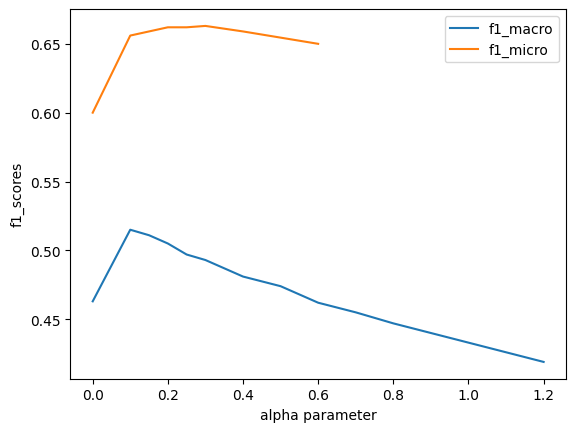

In [221]:
alpha_f1_macro = {'alpha': [0.0001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.2], 
                'f1_macro': [0.463, 0.515, 0.511, 0.505, 0.497, 0.493, 0.481, 0.474, 0.462, 0.455, 0.447, 0.419]}
alpha_f1_micro = {'alpha': [0.0001, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.6], 
                'f1_micro': [0.600, 0.656, 0.659, 0.662, 0.662, 0.663, 0.659, 0.650]}

plt.plot(alpha_f1_macro['alpha'], alpha_f1_macro['f1_macro'], label='f1_macro')
plt.plot(alpha_f1_micro['alpha'], alpha_f1_micro['f1_micro'], label='f1_micro')

plt.xlabel('alpha parameter')
plt.ylabel('f1_scores')
plt.legend()
plt.show()

In [ ]:
best_alpha = 0.1
OVR_NB_pipeline = Pipeline([
                ('Vectorizer', CountVectorizer(stop_words='english')),
                ('MultiNB', OneVsRestClassifier(MultinomialNB(alpha=best_alpha) ))    ])

In [ ]:
# evaluating classification models

models = {"Logistic Regression": LogisticRegression(), 
          "KNN": KNeighborsClassifier(), 
          "DecisionTree": DecisionTreeClassifier(),
          "LinearSVC": LinearSVC()}

In [248]:
X_train.iloc[2]

'professor marvin h mills is a self published crank his book is printed by iuniverse a vanity publishing company mills also believes that the mosques in spain were built by phoenicians aided by survivors from atlantis we learn of the piri reis map that it lead ivar zapp and george erikson in atlantis in america to assert that an awareness of antartica was known to an advanced civilization at the end of the ice age and yes the published version of this book really does spell the second word of that sentence with an a mills is not a reliable source he is self published and his views are fringe'

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

X_train = train_df['cleaner_text']
y = train_labels

X = CountVectorizer(stop_words='english').fit_transform(train_text)


In [11]:
fltr = train_df[train_df['identity_hate'] == 1] 
print(fltr.tail())


                                             cleaned_text  toxic  \
159281  lol you are gay you will never know how good i...      1   
159336  oh fuck off the pansy jew would just whine abo...      1   
159400  shalom semite get the fuck out of here i will ...      1   
159449                            i think he is a gay fag      1   
159494  our previous conversation you fucking shit eat...      1   

        severe_toxic  obscene  threat  insult  identity_hate  \
159281             1        1       0       1              1   
159336             0        1       0       1              1   
159400             1        1       1       1              1   
159449             0        0       0       0              1   
159494             0        1       0       1              1   

                                             cleaner_text  
159281         lol gay never know good feel fuck woman as  
159336  oh fuck pansy jew would whine bnai brith beat ...  
159400  shalom semite get 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [72]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_validate

smote = SMOTE()
rus = RandomUnderSampler()

MultiNB = MultinomialNB() # NB takes ~10s to train all labels
LR = LogisticRegression()  # LR takes > 2 min to train all labels

cv_all = pd.DataFrame()

for label in LABELS:
    
    X_smote, y_smote = smote.fit_resample(X_train, y_train[label])
    X_rus, y_rus = rus.fit_resample(X_train, y_train[label])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    score_evals = ['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1', 'neg_log_loss']
    cv = cross_validate(NB, X_rus, y_rus, cv=kf, scoring = score_evals, return_estimator=True)

    cv_df = pd.DataFrame(cv)
    cv_df.drop(['fit_time', 'score_time', 'estimator'], axis = 1, inplace = True) 
    
    print('Processing {} label'.format(label))
    display(cv_df)
    
    cv_mean = cv_df.mean()
    cv_all = pd.concat([cv_all, cv_mean], axis=1)

cv_all.columns = LABELS  # set the column names
cv_all.index = score_evals # set the index names

Processing toxic label


,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,test_neg_log_loss
0,0.868228,0.867674,0.905282,0.819118,0.860048,-0.837440
1,0.860896,0.861485,0.902232,0.813280,0.855450,-0.937038
2,0.875764,0.875314,0.899823,0.841866,0.869881,-0.817515
3,0.875127,0.875069,0.908082,0.834353,0.869658,-0.803532
4,0.871868,0.872533,0.913701,0.825231,0.867216,-0.790010


Processing severe_toxic label


,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,test_neg_log_loss
0,0.937751,0.937758,0.941176,0.937500,0.939335,-0.490504
1,0.945783,0.945802,0.942857,0.946721,0.944785,-0.402086
2,0.923695,0.923694,0.924000,0.924000,0.924000,-0.560068
3,0.927711,0.927894,0.913386,0.943089,0.928000,-0.323998
4,0.933735,0.933735,0.925197,0.943775,0.934394,-0.395155


Processing obscene label


,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,test_neg_log_loss
0,0.895594,0.895582,0.923810,0.862222,0.891954,-0.817217
1,0.900407,0.900732,0.924923,0.874177,0.898834,-0.864162
2,0.900370,0.899509,0.915663,0.874233,0.894468,-0.707633
3,0.904074,0.904011,0.921645,0.882615,0.901708,-0.737875
4,0.892593,0.893066,0.912519,0.874277,0.892989,-0.740492


Processing threat label


,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,test_neg_log_loss
0,0.895425,0.897003,0.860759,0.931507,0.894737,-0.607587
1,0.921569,0.922840,0.894737,0.944444,0.918919,-0.299312
2,0.901961,0.902654,0.881579,0.917808,0.899329,-0.726918
3,0.915033,0.914706,0.928571,0.917647,0.923077,-0.648640
4,0.894737,0.895613,0.920000,0.873418,0.896104,-0.422226


Processing insult label


,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,test_neg_log_loss
0,0.893397,0.893065,0.911168,0.868548,0.889348,-0.650839
1,0.871468,0.870480,0.909091,0.819805,0.862143,-0.941718
2,0.891365,0.891176,0.927448,0.848122,0.886013,-0.771260
3,0.884600,0.885083,0.924610,0.840157,0.880363,-0.833813
4,0.886988,0.888266,0.932874,0.840310,0.884176,-0.842813


Processing identity_hate label


,test_accuracy,test_balanced_accuracy,test_precision,test_recall,test_f1,test_neg_log_loss
0,0.885210,0.884822,0.883721,0.875576,0.879630,-0.622492
1,0.902870,0.902865,0.903509,0.903509,0.903509,-0.569741
2,0.913717,0.913627,0.930556,0.893333,0.911565,-0.556544
3,0.882743,0.883323,0.908257,0.857143,0.881960,-0.719595
4,0.896018,0.896416,0.917808,0.873913,0.895323,-0.673827


In [75]:
display(cv_all)

,toxic,severe_toxic,obscene,threat,insult,identity_hate
accuracy,0.870377,0.933735,0.898608,0.905745,0.885564,0.896111
balanced_accuracy,0.870415,0.933776,0.898580,0.906563,0.885614,0.896211
precision,0.905824,0.929323,0.919712,0.897129,0.921038,0.908770
recall,0.826770,0.939017,0.873505,0.916965,0.843389,0.880695
f1,0.864450,0.934103,0.895991,0.906433,0.880408,0.894397
neg_log_loss,-0.837107,-0.434362,-0.773476,-0.540937,-0.808088,-0.628440


In [64]:
cv_all.mean(axis=1)

accuracy             0.911811
balanced_accuracy    0.911623
precision            0.939029
recall               0.881478
f1                   0.909142
neg_log_loss        -0.280026
dtype: float64

In [62]:
cv_all.to_csv('scores_LR_rus.csv')

In [36]:
print(type(cv_df.mean()))

<class 'pandas.core.series.Series'>
Index(['test_balanced_accuracy', 'test_precision', 'test_recall', 'test_f1',
       'test_neg_log_loss'],
      dtype='object')


## Properly evaluate with testset

In [177]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, cross_validate
from sklearn.metrics import precision_recall_fscore_support

smote = SMOTE()
rus = RandomUnderSampler()

# model = MultinomialNB() # NB takes ~10s to train all labels
model = LogisticRegression()  # LR takes > 2 min to train all labels

label = 'obscene'

X_train, X_test, y_train, y_test = train_test_split(X, y[label], test_size=0.2)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

def model_train_evaluate(model, X_train, y_train, X_test, y_test, dec=2, verbose=False):

    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    # print('Processing {} label'.format(label))
    # print(classification_report(y_test, pred, output_dict=False))
    bal_acc = np.round(balanced_accuracy_score(y_test, pred), dec)
    prec, rec, f1 = np.round(precision_recall_fscore_support(y_test, pred, average='binary', pos_label=1)[:3] , dec)
    if verbose:
        print('bal_acc: {}, precision: {}, recall: {}, f1: {}'.format(bal_acc, prec, rec, f1) )  
    
    return bal_acc, prec, rec, f1


-- Multinomial Naive Bayes --
Original


(0.81, 0.65, 0.63, 0.64)

In [193]:
def train_evaluate_all_labels(models, X, y, label='toxic', verbose=False):
    '''
    models: dict, for iterating through classifier models
    X, y: pd.DataFrame, array-like
    label: string that matches the columns of data
    verbose: bool, for optional print outs
    '''
    
    X_train, X_test, y_train, y_test = train_test_split(X, y[label], test_size=0.2) # Original split
    X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train) # Random Under Sampling (RUS)
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train) #Synthetic Oversampling (SMOTE)
    
    n_0, n_1 = y_train.value_counts()
    imbalance_ratio = np.round(n_1/(n_0 + n_1), 3)
    
    train_sets = {'Original': [X_train, y_train], 
                    'RUS': [X_train_rus, y_train_rus], 
                    'SMOTE': [X_train_smote, y_train_smote]}
    
    scores = pd.DataFrame()  # initialize empty DF to store everything
    
    # iterate through the different training sets, must be in dictionary format
    for train_split, train_data in train_sets.items():  
        X_input, y_input = train_data
        
        # iterate through the classifier models, must be in dictionary format
        for model_name, model in models.items(): 
            
            bal_acc, prec, rec, f1 = model_train_evaluate(model, X_input, y_input, X_test, y_test, verbose= verbose)
            scores = scores.append({'label': label,
                                    'imbalance_ratio': imbalance_ratio, 
                                    'clf_model': model_name,
                                    'train_split': train_split,
                                    'balanced_accuracy': bal_acc,
                                    'precision': prec,
                                    'recall': rec,
                                    'f1_score': f1}, ignore_index=True)
            
    return scores


C:\Users\Feng\AppData\Local\Temp\ipykernel_28824\3616699757.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append({'label': label,
C:\Users\Feng\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Feng\AppData\Local\Temp\ipykernel_28824\3616699757.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas

,label,imbalance_ratio,clf_model,train_split,balanced_accuracy,precision,recall,f1_score
0,toxic,0.095,MultinomialNB,Original,0.79,0.71,0.61,0.66
1,toxic,0.095,LogisticRegression,Original,0.82,0.83,0.66,0.74
2,toxic,0.095,MultinomialNB,RUS,0.87,0.51,0.84,0.63
3,toxic,0.095,LogisticRegression,RUS,0.89,0.55,0.87,0.67
4,toxic,0.095,MultinomialNB,SMOTE,0.80,0.66,0.64,0.65
5,toxic,0.095,LogisticRegression,SMOTE,0.85,0.45,0.80,0.57
0,obscene,0.053,MultinomialNB,Original,0.79,0.64,0.60,0.62
1,obscene,0.053,LogisticRegression,Original,0.83,0.86,0.66,0.74
2,obscene,0.053,MultinomialNB,RUS,0.89,0.38,0.86,0.52
3,obscene,0.053,LogisticRegression,RUS,0.92,0.57,0.88,0.69


In [203]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression


models = {'MultinomialNB': MultinomialNB(), 'LogisticRegression': LogisticRegression()}
all_scores= pd.DataFrame()
LABELS = ['toxic', 'obscene', 'insult', 'severe_toxic', 'identity_hate', 'threat']

for label in LABELS:
    scores = train_evaluate_all_labels(models, X, y, label=label, verbose=False)
    # print(scores)
    all_scores = pd.concat([all_scores, scores], axis=0)
    

TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

In [200]:
# display(all_scores)
display(all_scores.groupby(['label']).mean().sort_values(by='imbalance_ratio'))
display(all_scores.groupby(['clf_model']).mean())
display(all_scores.groupby(['train_split']).mean())


C:\Users\Feng\AppData\Local\Temp\ipykernel_28824\462376751.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(all_scores.groupby(['label']).mean().sort_values(by='imbalance_ratio'))


,imbalance_ratio,balanced_accuracy,precision,recall,f1_score
label,,,,,
threat,0.003,0.696667,0.100000,0.431667,0.106667
identity_hate,0.009,0.751667,0.195000,0.545000,0.208333
severe_toxic,0.010,0.793333,0.245000,0.616667,0.293333
insult,0.050,0.815000,0.488333,0.676667,0.533333
obscene,0.053,0.851667,0.568333,0.743333,0.616667
toxic,0.095,0.836667,0.618333,0.736667,0.653333


C:\Users\Feng\AppData\Local\Temp\ipykernel_28824\462376751.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(all_scores.groupby(['clf_model']).mean())


,imbalance_ratio,balanced_accuracy,precision,recall,f1_score
clf_model,,,,,
LogisticRegression,0.036667,0.801667,0.390556,0.650556,0.410000
MultinomialNB,0.036667,0.780000,0.347778,0.599444,0.393889


C:\Users\Feng\AppData\Local\Temp\ipykernel_28824\462376751.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  display(all_scores.groupby(['train_split']).mean())


,imbalance_ratio,balanced_accuracy,precision,recall,f1_score
train_split,,,,,
Original,0.036667,0.6950,0.517500,0.401667,0.445000
RUS,0.036667,0.9025,0.285833,0.875833,0.389167
SMOTE,0.036667,0.7750,0.304167,0.597500,0.371667


In [209]:
display(all_scores.sort_values(by='balanced_accuracy', ascending=False))

,label,imbalance_ratio,clf_model,train_split,balanced_accuracy,precision,recall,f1_score
3,severe_toxic,0.010,LogisticRegression,RUS,0.94,0.20,0.92,0.33
2,severe_toxic,0.010,MultinomialNB,RUS,0.93,0.13,0.92,0.23
2,identity_hate,0.009,MultinomialNB,RUS,0.92,0.09,0.92,0.17
3,obscene,0.053,LogisticRegression,RUS,0.92,0.57,0.88,0.69
3,identity_hate,0.009,LogisticRegression,RUS,0.91,0.11,0.89,0.19
3,insult,0.050,LogisticRegression,RUS,0.91,0.42,0.89,0.57
2,obscene,0.053,MultinomialNB,RUS,0.89,0.38,0.86,0.52
3,threat,0.003,LogisticRegression,RUS,0.89,0.06,0.83,0.10
2,insult,0.050,MultinomialNB,RUS,0.89,0.38,0.85,0.52
3,toxic,0.095,LogisticRegression,RUS,0.89,0.55,0.87,0.67


In [183]:
d = {'a':[1,2], 'b':[3,4]}
for key, val in d.items():
    print(key)
    first, sec = val
    print(first)
    print(sec)

a
1
2
b
3
4


In [41]:
cm = confusion_matrix(pred, y_test)

tp, fp, tn, fn = cm[1,1], cm [1,0], cm[0,0], cm[0,1]  # 1's are true
tp, fp, tn, fn = cm[0,0], cm [0,1], cm[1,1], cm[1,0]  # 0's are true

prec = tp/(tp+fp)
print(prec)

0.9607903993378853
